# ITCS 3156-091 Final Project: Steam Review Sentiment Analysis

## Name: **Jason Khotsombath**

### Imports, Installs, and Utils

<b>Warning</b>: Please use the standard itcs-3156 kernal for the first imports and the code snippet below will install the rest that is needed.

In [105]:
%pip install wordcloud
%pip install nltk
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.


In [106]:
from typing import List, Dict, Tuple, Callable
import os
import gc
import traceback
import warnings
from pdb import set_trace

import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Steam Review Dataset

<center><img src="https://storage.googleapis.com/kaggle-datasets-images/1754525/2865229/aacab271ac39a043c556e617d148bb94/dataset-cover.png?t=2021-11-29-10-49-35"
width="600"
height="300"></img></center>

For my project, we will be using the [Steam Review Dataset](https://www.kaggle.com/datasets/andrewmvd/steam-reviews/data) by user [Larxel](https://www.kaggle.com/andrewmvd). This dataset contains 6.4 million publically available English reviews of from the Steam Reviews segment of the Steam store ran by Valve in 2017. On the Kaggle, the author suggests you can create a sentiment analysis algorithm to predict scores given review text and explore sentiment with review topics across games and genres. We will be doing the first option to predict scores based on review text. This is important specifically for game developers to understand player reception to their games, trend analysis for specific mechanics based on review text, and allows insights into what features/mechanics players value the most.

**Inputs/Features**

| Name                          | Data Name   | Description | Provided in Dataset |
|-------------------------------|------------|-------------|---------------|
| Game ID                    | app_id               | Unique ID of the game stored in the Steam Database | True |
| Game Name              | app_name         | Name of the Game stored in the Steam Database | True 
| Review Text                 | review_text          | The text input of the review text for that review | True |
| Review Text Word Count         | word_count | Number of words in the Review Text of that review | False |
| Review Votes | review_votes | Whether the review was recommended by another user or not | True |

**Target**

| Name                          | Data Name  | Description | Provided in Dataset |
|-------------------------------|-------------|-------------|----|
| Review Score | review_score     |  Whether the review recommends the game or not | True |

# Data Loading

In [107]:
# Make sure you download the dataset and place it in the same directory as this file.
# If the dataset is named as "dataset.csv", rename it to "SteamReviews.csv"
# Warning: The dataset is large, ~1-1.5min to load
steam_reviews_df = pd.read_csv('SteamReviews.csv')

In [108]:
# Sample Size
# steam_reviews_df = steam_reviews_df.sample(n=10000, random_state=np.random.randint(0,10000))
steam_reviews_df = steam_reviews_df.sample(n=10000, random_state=42)

In [109]:
# Adding Word Count as a feature
steam_reviews_df['word_count'] = steam_reviews_df['review_text'].str.split().str.len()

In [110]:
steam_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 301327 to 2910898
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   app_id        10000 non-null  int64  
 1   app_name      9717 non-null   object 
 2   review_text   9989 non-null   object 
 3   review_score  10000 non-null  int64  
 4   review_votes  10000 non-null  int64  
 5   word_count    9989 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 546.9+ KB


In [111]:
steam_reviews_df.describe()

,app_id,review_score,review_votes,word_count
count,10000.000000,10000.000000,10000.000000,9989.000000
mean,229031.791300,0.632400,0.148200,55.609270
std,124891.034596,0.774681,0.355316,109.781069
min,10.000000,-1.000000,0.000000,0.000000
25%,202970.000000,1.000000,0.000000,6.000000
50%,240760.000000,1.000000,0.000000,20.000000
75%,304930.000000,1.000000,0.000000,57.000000
max,556130.000000,1.000000,1.000000,1363.000000


# Visualization

## Numeric Features
### Correlation between all numeric features

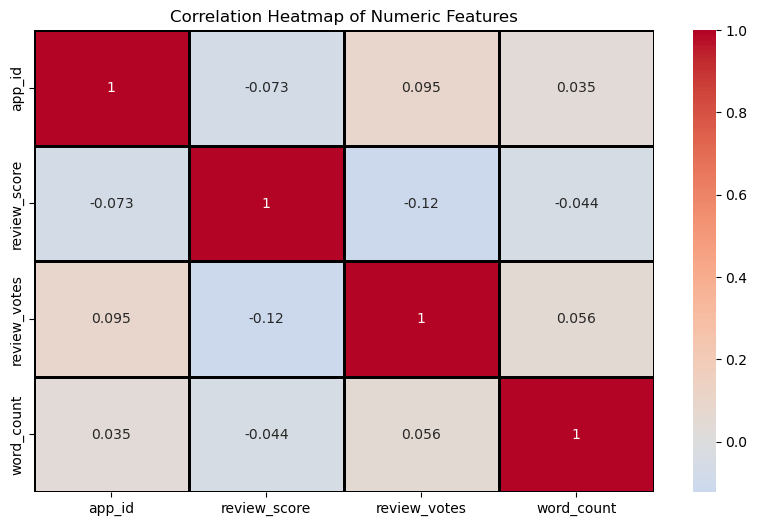

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_df = steam_reviews_df.drop(columns=['review_text', 'app_name'])

plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', center=0, linewidths=1, linecolor='black'),
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

## Word Count by Sentiment
### Distribution of word count by sentiment

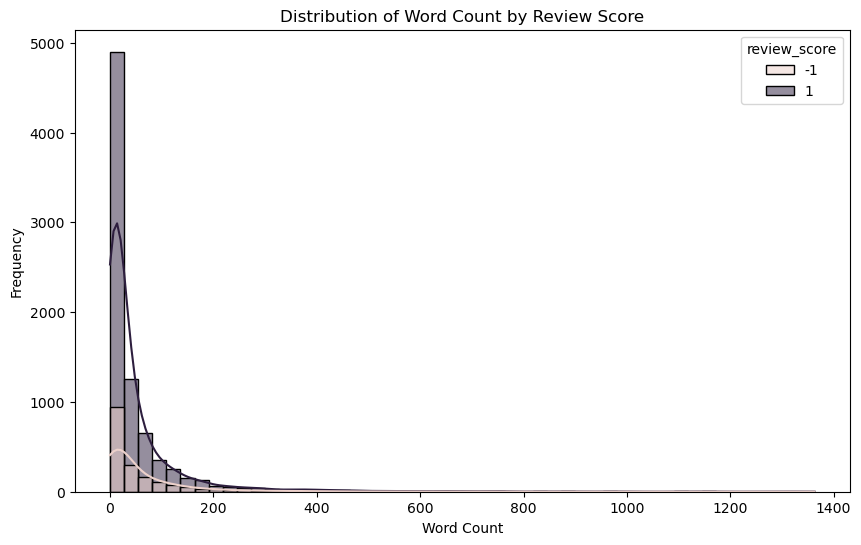

In [113]:
plt.figure(figsize=(10, 6))
sns.histplot(data=steam_reviews_df, x='word_count', hue='review_score', bins=50, kde=True)
plt.title('Distribution of Word Count by Review Score')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

## Game Distribution
### Top Games by review count
Note: Game Distribution varies greatly due to the chosen random seed and n sample size. These games do not accurately suggest the amount of review that they may actually have, nor be as high as other games. Everytime steam_reviews_df is read and give its smaller sample, this list may change.

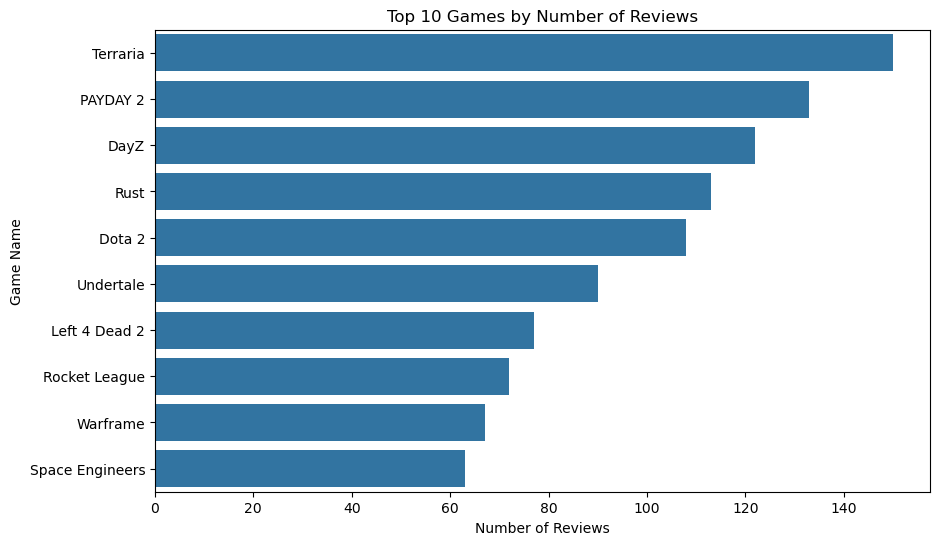

In [114]:
top_games_df = steam_reviews_df['app_name'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_games_df.values, y=top_games_df.index)
plt.title('Top 10 Games by Number of Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Game Name')
plt.show()

## Sentiment Score Distribution
### Pie Chart of Postive to Negative Reviews

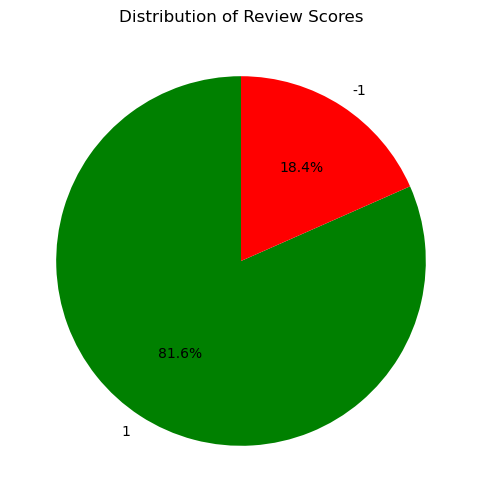

In [115]:
plt.figure(figsize=(10, 6))
steam_reviews_df['review_score'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['green', 'red'])
plt.title('Distribution of Review Scores')
plt.ylabel('')
plt.show()

## Word Cloud
### Word clouds of the most common words for positive and negative reviews.

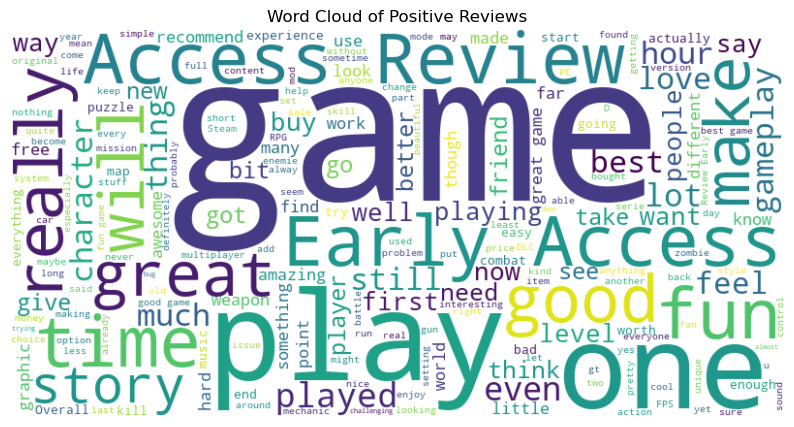

In [116]:
from wordcloud import WordCloud

steam_reviews_df['review_text'] = steam_reviews_df['review_text'].astype(str).replace('nan', '')
positive_text = ' '.join(steam_reviews_df[steam_reviews_df['review_score'] == 1]['review_text'])
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

plt.figure(figsize=(10, 6))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Positive Reviews')
plt.show()

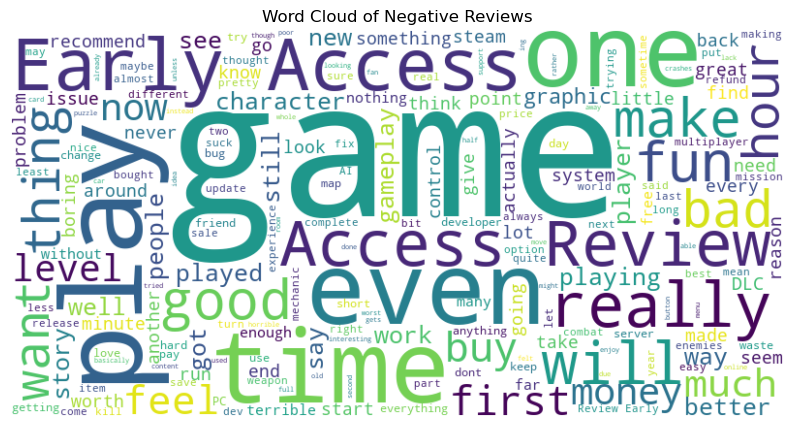

In [117]:
negative_text = ' '.join(steam_reviews_df[steam_reviews_df['review_score'] == -1]['review_text'])
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.figure(figsize=(10, 6))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Negative Reviews')
plt.show()

# Data Splitting and Preprocessing 

## Text Preprocessing
The usage of text preprocessing is removing unnessecary values in our dataset such as: HTML Tags, URLs, special characters and numbers, and stop words (the, and, a, etc...). Additionally, we're tokenizing each of the words and pushing through a lemmatization tool (WordNet Lemmatizer).

In [118]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize

nltk_data_path = os.path.join(os.getcwd(), 'nltk_data')
os.makedirs(nltk_data_path, exist_ok=True)
nltk.data.path.insert(0, nltk_data_path)

try:
    nltk.download('punkt', download_dir=nltk_data_path, quiet=True)
    nltk.download('punkt_tab', download_dir=nltk_data_path, quiet=True)
    nltk.download('stopwords', download_dir=nltk_data_path, quiet=True)
    nltk.download('wordnet', download_dir=nltk_data_path, quiet=True)
except Exception as e:
    print(f"Error downloading NLTK data: {e}")
    traceback.print_exc()

# Cache Variables
stop_words = set(stopwords.words('english'))
stop_word_method = PorterStemmer()
# stop_word_method = WordNetLemmatizer()  # Uncomment this line to use lemmatization

def preprocess_text(text:str) -> str:
    """
    Preprocess the text by removing special characters, converting to lowercase,
    removing stopwords, and lemmatizing the words.

    Args:
        text (str): The input text to preprocess.

    Returns:
        str: The cleaned and preprocessed text.
    """

    if not isinstance(text, str) or not text.strip():
        return ''
    
    # Lowercase text
    text = text.lower()

    # Remove HTML tags, special characters, numbers, and URLs
    text = text = re.sub(r'<.*?>|http\S+|www\S+|https\S+|[^a-zA-Z\s]', ' ', text)


    # Tokenize input
    tokens = word_tokenize(text)
    
    # Remove Stop Words and lemmatize
    
    tokens = [stop_word_method.stem(word) for word in tokens if word not in stop_words and len(word) > 1]
    # tokens = [stop_word_method.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 1]

    # Puts tokens back into a string
    processed_text = ' '.join(tokens)
    
    # print (f"Processed text: {processed_text}")
    return processed_text


## Feature Extraction
Here we're extracting additional features to aid in predicating review/sentiment score. These values often correlate to review score.

In [119]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix

def extract_features(df: pd.DataFrame) -> Tuple[object, object]:
    """
    Extract features from the review text using TF-IDF or Count Vectorization.

    Args:
        df (pd.DataFrame): The DataFrame containing the preprocessed text.
        feature_extraction_method (str): The method to use for feature extraction ('tfidf').

    Returns:
        Tuple: [X_train, y_train, X_valid, y_valid, X_test, y_test, vectorizer]
    """

    df['processed_text'] = df['review_text'].apply(preprocess_text)

    df['word_count'] = df['processed_text'].str.split().str.len()
    df['char_count'] = df['processed_text'].str.len()
    df['avg_word_length'] = df.apply(lambda x: x['char_count'] / x['word_count'] if x['word_count'] > 0 else 0, axis=1)
    df['punctuation_count'] = df['processed_text'].str.count(r'[^\w\s]')

    # Extract features using TF-IDF Vectorization
    vectorizer = TfidfVectorizer(max_features=3000, stop_words='english', min_df=2 ,max_df=0.8, sublinear_tf=True)
    text_features = vectorizer.fit_transform(df['processed_text']).toarray()

    additional_features = df[['word_count', 'char_count', 'avg_word_length', 'punctuation_count']].values

    # Convert to sparse matrix
    additional_features_sparse = csr_matrix(additional_features)

    X = np.hstack((text_features, additional_features_sparse.toarray()))
    y = df['review_score'].values

    X_trn, X_tst, y_trn, y_tst =  train_test_split(X, y, test_size=0.2, random_state=42)
    X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn, y_trn, test_size=0.2, random_state=42)

    return X_trn, y_trn, X_vld, y_vld, X_tst, y_tst, vectorizer

## Data Processing
### Putting it all together

In [120]:
def get_preprocessed_data(df: pd.DataFrame) -> Tuple[object, object]:
    """
    Preprocess the data and extract features.

    Args:
        df (pd.DataFrame): The DataFrame containing the review text.
        feature_extraction_method (str): The method to use for feature extraction ('tfidf').

    Returns:
        Tuple: [X_train, y_train, X_valid, y_valid, X_test, y_test]
    """

    # Data Safety Check
    df['review_score'] = df['review_score'].apply(lambda x: 1 if x == 1 else -1)

    # Preprocess the data and extract features
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst, vectorizer = extract_features(df)

    additional_feature_count = 4  # word_count, char_count, avg_word_length, punctuation_count
    scaler = sklearn.preprocessing.StandardScaler()

    # Scale the additional features by sparse matrix then recombine with the text features into dense matrix
    def scale_sparse_features(X: np.ndarray, scaler: sklearn.preprocessing.StandardScaler, fit: bool = False):
        n_features = X.shape[1]
        start_idx = n_features - additional_feature_count

        text_features = X[:, :start_idx]
        additional_features = X[:, start_idx:]
        
        if fit:
            additional_features = scaler.fit_transform(additional_features)
        else:
            additional_features = scaler.transform(additional_features)

        return np.hstack([text_features, csr_matrix(additional_features).toarray()])

    X_trn = scale_sparse_features(X_trn, scaler, fit=True)
    X_vld = scale_sparse_features(X_vld, scaler, fit=False)
    X_tst = scale_sparse_features(X_tst, scaler, fit=False)

    return X_trn, y_trn.reshape(-1, 1), X_vld, y_vld.reshape(-1, 1), X_tst, y_tst.reshape(-1, 1), vectorizer

In [121]:
def test_data_preprocessing_pipeline(df: pd.DataFrame = steam_reviews_df) -> bool:
    """
    Test the text preprocessing pipeline with sample reviews.
    """

    print("Testing the text preprocessing pipeline...")

    # Text Preprocessing Test
    sample_text = 'This is a www.testingL!ink.com with 123 numbers, <html> <b>tags</b>, and some punctuation!'
    processed = preprocess_text(sample_text)
    print(f"Original text: {sample_text}")
    print(f"Processed text: {processed}")

    assert isinstance(processed, str), "Processed text should be a string."
    assert len(processed) > 0, "Processed text should not be empty."
    assert all(char.isalpha() or char.isspace() for char in processed), "Processed text should only contain letters and spaces."
    assert 'www' not in processed, "Processed text should not contain URLs."
    assert '<html>' not in processed, "Processed text should not contain HTML tags."
    assert '123' not in processed, "Processed text should not contain numbers."
    assert '!' not in processed, "Processed text should not contain punctuation."

    print("Basic Text Processing Test passed!")

    test_df = df.head(100).copy()

    # Shape Test
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst, vectorizer = extract_features(test_df)
    assert X_trn.shape[0] + X_vld.shape[0] + X_tst.shape[0] == 100, "Data split should preserve the number of samples."
    assert X_trn.shape[1] == X_vld.shape[1] == X_tst.shape[1], "Feature dimensions should match across splits."

    # Feature List Test
    assert 'word_count' in test_df.columns, "word_count should be in the DataFrame."
    assert 'char_count' in test_df.columns, "char_count should be in the DataFrame."
    assert 'avg_word_length' in test_df.columns, "avg_word_length should be in the DataFrame."
    assert 'punctuation_count' in test_df.columns, "punctuation_count should be in the DataFrame."

    # word_count Test
    sample_row = test_df.iloc[0]
    expected_word_count = len(sample_row['processed_text'].split())
    print(f"Sample processed text: {sample_row['processed_text']}")
    print(f"Expected word count: {expected_word_count}")
    assert sample_row['word_count'] == expected_word_count, "word_count should match the number of words in processed_text."
    print(f"Actual word count: {sample_row['word_count']}")

    print("Feature Extraction Test passed!")

    # Vectorizer Test
    vocab = vectorizer.get_feature_names_out()
    print(f"Vocabulary size: {len(vocab)}")
    assert len(vocab) > 0, "Vectorizer should have a non-empty vocabulary."
    assert len(vocab) <= 5000, "Vectorizer should have, at most, 5000 features."

    new_text = "This game is amazing!"
    new_text_vectorized = preprocess_text(new_text)
    transformed_text = vectorizer.transform([new_text_vectorized]).toarray()

    print(f"Transformed text shape: {transformed_text.shape}")
    print(f'Transformed text: {transformed_text}')
    assert transformed_text.shape[1] == len(vocab), "Transformed text should have the same number of features as the vocabulary."
    assert transformed_text.shape[0] == 1, "Transformed text should have one row."

    print("Vectorizer Test passed!")

    # End to End Test
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst, vectorizer = get_preprocessed_data(test_df)

    text_feature_count = X_trn.shape[1] - 4  # Subtracting the number of additional features
    additional_feature_count = X_trn[:, text_feature_count:]
    assert abs(additional_feature_count.mean()) < 0.1, "Additional features should be centered around 0."
    assert abs(additional_feature_count.std() - 1.0) > 0.1, "Additional features should have some variance."

    print("End to End Test passed!")

    # Transformation Test
    assert set(np.unique(y_trn)) <= {-1, 1}, "y_train should only contain -1 and 1."
    assert y_trn.shape[1] == 1, "y_train should be a 2D array with one column."

    print("Transformation Test passed!")

    print("All tests passed!")
    return True


test_data_preprocessing_pipeline(steam_reviews_df)

Testing the text preprocessing pipeline...
Original text: This is a www.testingL!ink.com with 123 numbers, <html> <b>tags</b>, and some punctuation!
Processed text: number tag punctuat
Basic Text Processing Test passed!
Sample processed text: best bowl simul good storylin
Expected word count: 5
Actual word count: 5
Feature Extraction Test passed!
Vocabulary size: 272
Transformed text shape: (1, 272)
Transformed text: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

True

# Methods

## Multinomial Naives Bayes
Here we are using sklearn's multinomial Naive Bayes as opposed to the Gaussian Naives Bayes in class. Multinomial Naive Bayes has a few advanatages when it comes to this specific project.<br><br>
&#x2022; Ideal for discrete data and used in text classification; hence used in NLP<br>
&#x2022; Models frequency of words as counts<br>
&#x2022; More efficient with a higher number of features like datasets with thousands of words<br>
&#x2022; Doesn't assume or follow a gaussian distribution for likelihood<br><br>

In [122]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV
import sklearn.preprocessing

def evaluate_naive_bayes_model(X_trn, y_trn, X_vld, y_vld, X_tst, y_tst):
    """
    Train and evaluate the Multinomial Naive Bayes Model.

    Args:
        X_trn (np.ndarray): Training feature set.
        y_trn (np.ndarray): Training labels.
        X_vld (np.ndarray): Validation feature set.
        y_vld (np.ndarray): Validation labels.
        X_tst (np.ndarray): Test feature set.
        y_tst (np.ndarray): Test labels.


    """

    num_features = X_trn.shape[1]
    num_additional_features = 4
    text_feature_count = num_features - num_additional_features

    # Ensures non-negative values for TF-IDF features
    X_trn_tfidf = X_trn[:, :text_feature_count]
    X_vld_tfidf = X_vld[:, :text_feature_count]
    X_tst_tfidf = X_tst[:, :text_feature_count]

    X_trn_tfidf = np.maximum(0, X_trn_tfidf)
    X_vld_tfidf = np.maximum(0, X_vld_tfidf)
    X_tst_tfidf = np.maximum(0, X_tst_tfidf)

    scaler = sklearn.preprocessing.MinMaxScaler()
    X_trn_additional = X_trn[:, text_feature_count:]
    X_vld_additional = X_vld[:, text_feature_count:]
    X_tst_additional = X_tst[:, text_feature_count:]
    X_trn_additional = scaler.fit_transform(X_trn_additional)
    X_vld_additional = scaler.transform(X_vld_additional)
    X_tst_additional = scaler.transform(X_tst_additional)

    # Combine TF-IDF and additional features
    X_trn_nb = np.hstack((X_trn_tfidf, X_trn_additional))
    X_vld_nb = np.hstack((X_vld_tfidf, X_vld_additional))
    X_tst_nb = np.hstack((X_tst_tfidf, X_tst_additional))


    # Data Preprocessing for **Multinomial** Naive Bayes
    # Convert y to binary values (0 and 1) for Multinomial Naive Bayes
    y_trn_nb = (y_trn.reshape(-1) + 1) // 2
    y_vld_nb = (y_vld.reshape(-1) + 1) // 2
    y_tst_nb = (y_tst.reshape(-1) + 1) // 2

    # Hyperparameter Tuning
    param_grid = {
        'alpha': [0.01, 0.1, 0.5, 1.0, 2.0],
        'fit_prior': [True, False]
    }

    nb_model = MultinomialNB()

    grid_search = GridSearchCV(nb_model, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
    grid_search.fit(X_trn_nb, y_trn_nb)

    best_model = grid_search.best_estimator_
    print(f'Best parameters: {grid_search.best_params_}')

    # Performance Evaluation on Validation Set
    y_vld_pred = best_model.predict(X_vld_nb)

    accuracy = accuracy_score(y_vld_nb, y_vld_pred)
    precision = precision_score(y_vld_nb, y_vld_pred, zero_division=0)
    recall = recall_score(y_vld_nb, y_vld_pred, zero_division=0)
    f1 = f1_score(y_vld_nb, y_vld_pred, zero_division=0)

    y_vld_proba = best_model.predict_proba(X_vld_nb)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_vld_nb, y_vld_proba)
    roc_auc = auc(fpr, tpr)

    cm = confusion_matrix(y_vld_nb, y_vld_pred)

    print(f'Validation Accuracy: {accuracy}')
    print(f'Validation Precision: {precision}')
    print(f'Validation Recall: {recall}')
    print(f'Validation F1 Score: {f1}')
    print(f'Validation ROC AUC: {roc_auc}')

    # Plotting the confusion matrix
    plt.figure(figsize=(10, 6))
    plt.title('Confusion Matrix - Naive Bayes')
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Plotting the ROC curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - Naive Bayes')
    plt.legend(loc='lower right')
    plt.show()

    # Feature Importance
    if hasattr(best_model, 'feature_log_prob_'):
        feature_importance = best_model.feature_log_prob_[1] - best_model.feature_log_prob_[0]

        n_features = 20
        indices = np.argsort(feature_importance)
        top_negative_features = indices[:n_features]
        top_positive_features = indices[-n_features:][::-1]

        print('Top Positive Features:')
        for i in top_positive_features:
            if i < len(feature_importance) - 4:
                print(f'{i}: {feature_importance[i]}')
        
        print('\nTop Negative Features:')
        for i in top_negative_features:
            if i < len(feature_importance) - 4:
                print(f'{i}: {feature_importance[i]}')

    # Performance Evaluation on Test Set
    y_tst_pred = best_model.predict(X_tst_nb)

    test_accuracy = accuracy_score(y_tst_nb, y_tst_pred)
    test_precision = precision_score(y_tst_nb, y_tst_pred, zero_division=0)
    test_recall = recall_score(y_tst_nb, y_tst_pred, zero_division=0)
    test_f1 = f1_score(y_tst_nb, y_tst_pred, zero_division=0)
    test_roc_auc = auc(fpr, tpr)

    y_tst_proba = best_model.predict_proba(X_tst_nb)[:, 1]
    test_fpr, test_tpr, test_thresholds = roc_curve(y_tst_nb, y_tst_proba)
    test_roc_auc = auc(test_fpr, test_tpr)

    print('Test Metrics:')
    print(f'Test Accuracy: {test_accuracy}')
    print(f'Test Precision: {test_precision}')
    print(f'Test Recall: {test_recall}')
    print(f'Test F1 Score: {test_f1}')
    print(f'Test ROC AUC: {test_roc_auc}')

    # Storing metrics
    metrics = {
        'model_name': 'Multinomial Naive Bayes',
        'best_params': grid_search.best_params_,
        'validation': {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'confusion_matrix': cm,
            'fpr': fpr,
            'tpr': tpr,
        },
        'test': {
            'accuracy': test_accuracy,
            'precision': test_precision,
            'recall': test_recall,
            'f1_score': test_f1,
            'roc_auc': test_roc_auc,
            'fpr': test_fpr,
            'tpr': test_tpr,
        }
    }

    return best_model, metrics


## Neural Networks
Here we're utilizing Tensorflow's neural network framework to create our model. We are using their sequential architecture with ReLU activation functions and other algorithms to prevent overfitting and help generalize the data.

In [123]:
import tensorflow as tf

def evaluate_neural_network_model(X_trn, y_trn, X_vld, y_vld, X_tst, y_tst):
    """
    Train and evaluate a Neural Network model.

    Args:
        X_trn (np.ndarray): Training feature set.
        y_trn (np.ndarray): Training labels.
        X_vld (np.ndarray): Validation feature set.
        y_vld (np.ndarray): Validation labels.
        X_tst (np.ndarray): Test feature set.
        y_tst (np.ndarray): Test labels.

    Returns:
        Tuple: [model, metrics]
    """

    tf.random.set_seed(42)
    input_dim = X_trn.shape[1]

    # Define the Neural Network model
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001), input_shape=(input_dim,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Early Stopping Callback
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

    y_trn_nn = (y_trn.reshape(-1) + 1) // 2
    y_vld_nn = (y_vld.reshape(-1) + 1) // 2
    y_tst_nn = (y_tst.reshape(-1) + 1) // 2

    # Train the model
    history = model.fit(X_trn, y_trn_nn, epochs=20, batch_size=32, callbacks=[early_stopping], validation_data=(X_vld, y_vld_nn), verbose=1)

    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Performance Evaluation on Validation Set
    y_vld_proba = model.predict(X_vld, verbose=0)
    y_vld_pred = (y_vld_proba > 0.5).astype(int).reshape(-1)

    accuracy = accuracy_score(y_vld_nn, y_vld_pred)
    precision = precision_score(y_vld_nn, y_vld_pred, zero_division=0)
    recall = recall_score(y_vld_nn, y_vld_pred, zero_division=0)
    f1 = f1_score(y_vld_nn, y_vld_pred, zero_division=0)
    fpr, tpr, thresholds = roc_curve(y_vld_nn, y_vld_proba)
    roc_auc = auc(fpr, tpr)

    cm = confusion_matrix(y_vld_nn, y_vld_pred)

    # Validation Metrics
    print(f'Validation Accuracy: {accuracy}')
    print(f'Validation Precision: {precision}')
    print(f'Validation Recall: {recall}')
    print(f'Validation F1 Score: {f1}')
    print(f'Validation ROC AUC: {roc_auc}')
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix - Neural Network')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # ROC Curve Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - Neural Network')
    plt.legend(loc='lower right')
    plt.show()

    # Performance Evaluation on Test Set
    y_tst_proba = model.predict(X_tst, verbose=0)
    y_tst_pred = (y_tst_proba > 0.5).astype(int).reshape(-1)

    test_accuracy = accuracy_score(y_tst_nn, y_tst_pred)
    test_precision = precision_score(y_tst_nn, y_tst_pred, zero_division=0)
    test_recall = recall_score(y_tst_nn, y_tst_pred, zero_division=0)
    test_f1 = f1_score(y_tst_nn, y_tst_pred, zero_division=0)
    test_fpr, test_tpr, test_thresholds = roc_curve(y_tst_nn, y_tst_proba)
    test_roc_auc = auc(test_fpr, test_tpr)

    # Test Metrics
    print(f'Test Accuracy: {test_accuracy}')
    print(f'Test Precision: {test_precision}')
    print(f'Test Recall: {test_recall}')
    print(f'Test F1 Score: {test_f1}')
    print(f'Test ROC AUC: {test_roc_auc}')

    metrics = {
        'model_name': 'Neural Network',
        'validation': {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'confusion_matrix': cm,
            'fpr': fpr,
            'tpr': tpr,
            'history': history.history,
        },
        'test': {
            'accuracy': test_accuracy,
            'precision': test_precision,
            'recall': test_recall,
            'f1_score': test_f1,
            'roc_auc': test_roc_auc,
            'fpr': test_fpr,
            'tpr': test_tpr,
        }
    }

    return model, metrics


# Metrics and Performance Evaluations

In [124]:
def compare_models(nb_metrics, nn_metrics) -> None:
    """
    Compare the performance of the Naive Bayes and Neural Network models.

    Args:
        nb_metrics (dict): Metrics for the Naive Bayes model.
        nn_metrics (dict): Metrics for the Neural Network model.
    """

    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
    model_names = ['Naive Bayes', 'Neural Network']

    comparison_data = []
    for metric in metrics:
        comparison_data.append([nb_metrics['test'][metric], nn_metrics['test'][metric]])

    comparison_df = pd.DataFrame(comparison_data, columns=model_names, index=metrics)

    print('Model Comparison - Test Metrics')
    print(comparison_df)

    plt.figure(figsize=(10, 6))
    comparison_df.plot(kind='bar', rot=0)
    plt.title('Model Comparison - Test Metrics')
    plt.ylabel('Score')
    plt.ylim([0, 1])
    plt.legend(title='Model')
    plt.grid(axis='y')

    for i in range(len(comparison_df.index)):
        for j in range(len(comparison_df.columns)):
            plt.text(j, comparison_df.iloc[i, j] + 0.02, f'{comparison_df.iloc[i, j]:.2f}', ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(nb_metrics['test']['fpr'], nb_metrics['test']['tpr'], label='Naive Bayes ROC Curve')
    plt.plot(nn_metrics['test']['fpr'], nn_metrics['test']['tpr'], label='Neural Network ROC Curve')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - Model Comparison')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    return


In [125]:
def analyze_model_performance(model, X_tst, y_tst, vectorizer, df_tst) -> None:
    """
    Analyze the performance of the model on the test set.

    Args:
        model (object): The trained model.
        X_tst (np.ndarray): Test feature set.
        y_tst (np.ndarray): Test labels.
        vectorizer (object): The vectorizer used for feature extraction.
    """

    if isinstance(model, MultinomialNB):
        y_tst_format = (y_tst.reshape(-1) + 1) // 2
        y_pred = model.predict(X_tst)
    else:
        y_tst_format = (y_tst.reshape(-1) + 1) // 2
        y_tst_proba = model.predict(X_tst, verbose=0)
        y_pred = (y_tst_proba > 0.5).astype(int).reshape(-1)

    misclassified_indices = np.where(y_tst_format != y_pred)[0]

    if len(misclassified_indices) == 0:
        print('No misclassified samples found.')
        return

    num_examples = min(10, len(misclassified_indices))
    sample_indices = np.random.choice(misclassified_indices, num_examples, replace=False)

    print(f'Misclassified Samples ({num_examples}):')
    for i, idx in enumerate(sample_indices):
        actual_label = 'Positive' if y_tst_format[idx] == 1 else 'Negative'
        predicted_label = 'Positive' if y_pred[idx] == 1 else 'Negative'

        print(f'\nSample {i + 1}')
        print(f"Review: {df_tst['review_text'].iloc[idx][:200]}...")
        print(f'Actual Sentiment: {actual_label}')
        print(f'Predicted Sentiment: {predicted_label}')

        if not isinstance(model, MultinomialNB):
            confidence = y_tst_proba[idx][0]
            print(f'Predicted Probability: {confidence}')
        
    print('Common characteristics of misclassified examples:')
    correctly_classified = df_tst.iloc[np.where(y_tst_format == y_pred)[0]]
    misclassified = df_tst.iloc[misclassified_indices]

    avg_correct_length = correctly_classified['review_text'].str.len().mean()
    avg_misclassified_length = misclassified['review_text'].str.len().mean()

    print(f'Average Length of Correctly Classified Reviews: {avg_correct_length}')
    print(f'Average Length of Misclassified Reviews: {avg_misclassified_length}')

    misclassified_positive = np.sum(y_tst_format[misclassified_indices] == 1)
    misclassified_negative = np.sum(y_tst_format[misclassified_indices] == 0)

    print(f'Number of Misclassified Positive Reviews: {misclassified_positive}')
    print(f'Number of Misclassified Negative Reviews: {misclassified_negative}')

    return

# Results

In [126]:
X_trn, y_trn, X_vld, y_vld, X_tst, y_tst, vectorizer = get_preprocessed_data(steam_reviews_df)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'alpha': 0.1, 'fit_prior': True}
Validation Accuracy: 0.845625
Validation Precision: 0.8489583333333334
Validation Recall: 0.9886277482941622
Validation F1 Score: 0.9134851138353766
Validation ROC AUC: 0.8113798062265438


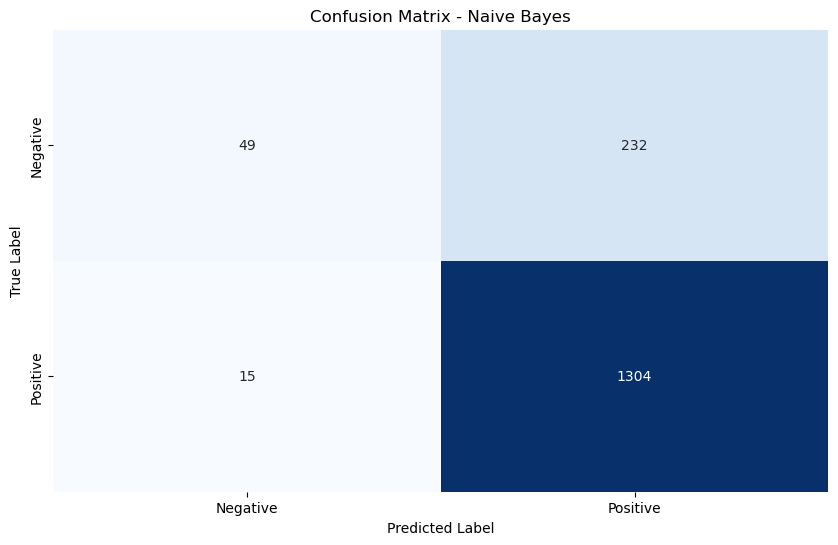

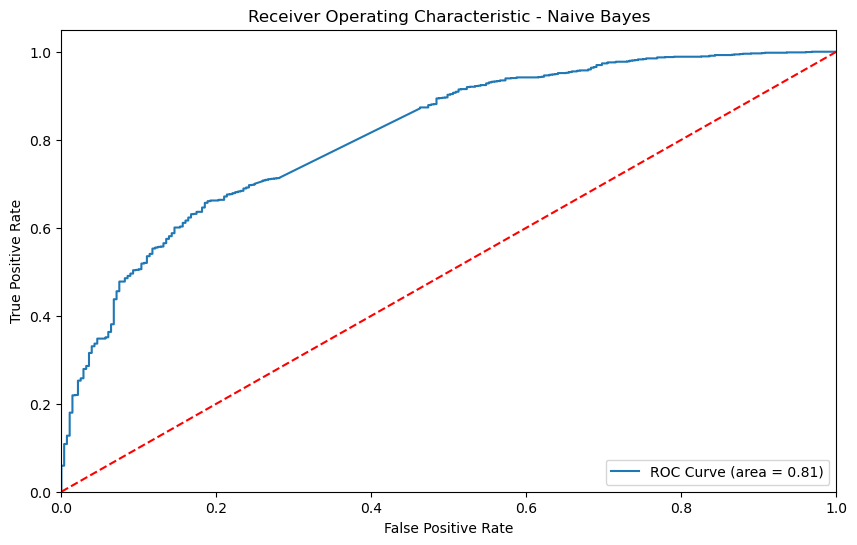

Top Positive Features:
2135: 3.2460016779582217
2979: 3.098597184191579
188: 3.0498782742556028
1132: 2.9918524729947364
1825: 2.7747631057476063
1159: 2.763911923749573
324: 2.7415706891448632
2709: 2.736643367814194
1215: 2.7214149903849574
755: 2.636353238982881
2635: 2.543219099844096
252: 2.5339421323686917
1412: 2.405726371735449
262: 2.4022286422323678
1184: 2.400813185061976
2931: 2.387222878593297
2900: 2.373932074647911
2309: 2.3476069761501
2194: 2.3379104483205424
833: 2.335052347827146

Top Negative Features:
2265: -4.367398295540441
2235: -3.90169307043098
1664: -3.850943865598209
1832: -3.804674305323461
1857: -3.662147230333071
1095: -3.61107130876968
756: -3.473186168194294
1862: -3.304818654706299
1071: -3.2961728114810533
2898: -3.0718791948790525
2122: -3.0105836626303564
832: -2.991261519824187
1509: -2.981413045013799
1161: -2.91751709134523
1051: -2.9156666880848956
1347: -2.8748802363698616
2342: -2.8691917762024257
713: -2.7802890640542177
564: -2.7680942245567

In [127]:
nb_model, nb_metrics = evaluate_naive_bayes_model(X_trn, y_trn, X_vld, y_vld, X_tst, y_tst)

c:\Users\jason\anaconda3\envs\itcs-3156\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.5871 - loss: 1.2985 - val_accuracy: 0.8244 - val_loss: 0.9119
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7731 - loss: 0.9644 - val_accuracy: 0.8244 - val_loss: 0.8815
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8283 - loss: 0.8628 - val_accuracy: 0.8456 - val_loss: 0.8371
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8680 - loss: 0.7722 - val_accuracy: 0.8512 - val_loss: 0.8244
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.8834 - loss: 0.6858 - val_accuracy: 0.8469 - val_loss: 0.8176
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.8974 - loss: 0.6405 - val_accuracy: 0.8425 - val_loss: 0.7967
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.9073 - loss: 0.5893 - val_accuracy: 0.8481 - val_loss: 0.8198
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9198 - loss: 0.5370 - val_acc

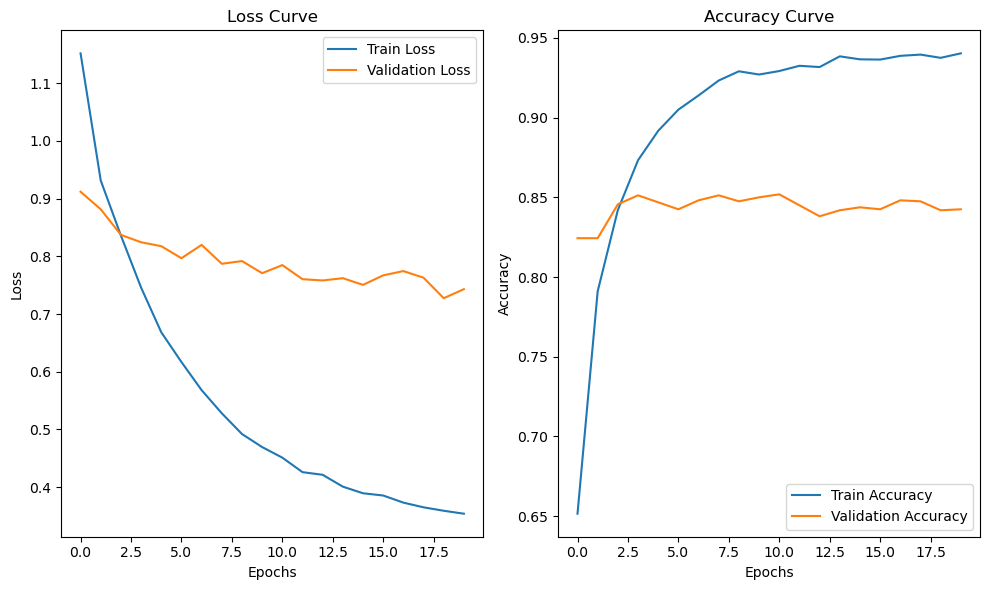

Validation Accuracy: 0.841875
Validation Precision: 0.8722067039106145
Validation Recall: 0.9469294920394238
Validation F1 Score: 0.9080334423845874
Validation ROC AUC: 0.7717792784893116


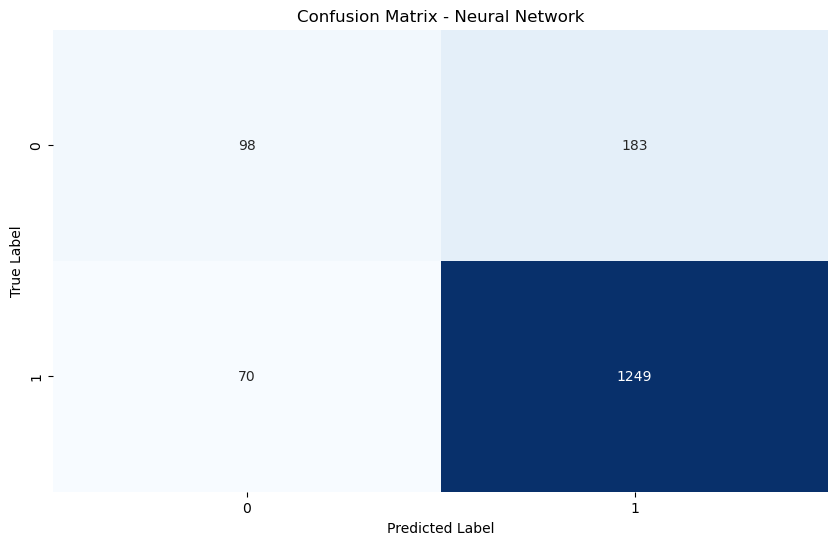

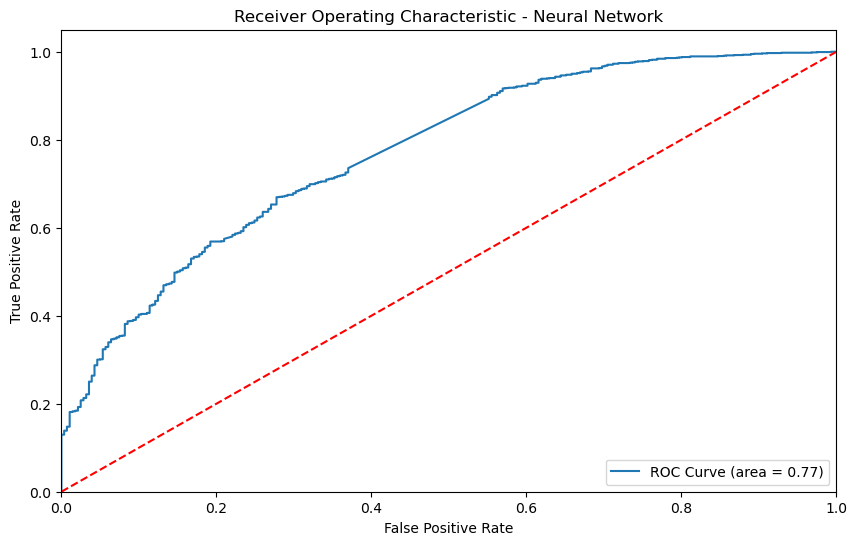

Test Accuracy: 0.839
Test Precision: 0.8688801350590883
Test Recall: 0.9454990814451929
Test F1 Score: 0.9055718475073313
Test ROC AUC: 0.8036486899122494


In [128]:
nn_model, nn_metrics = evaluate_neural_network_model(X_trn, y_trn, X_vld, y_vld, X_tst, y_tst)

Model Comparison - Test Metrics
           Naive Bayes  Neural Network
accuracy      0.842500        0.839000
precision     0.845026        0.868880
recall        0.988365        0.945499
f1_score      0.911092        0.905572
roc_auc       0.823352        0.803649


<Figure size 1000x600 with 0 Axes>

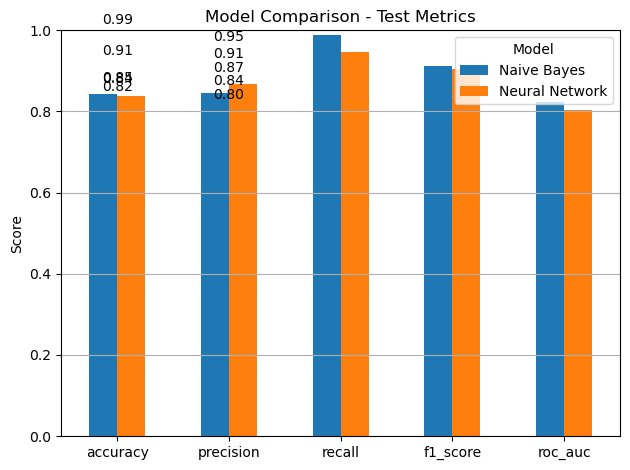

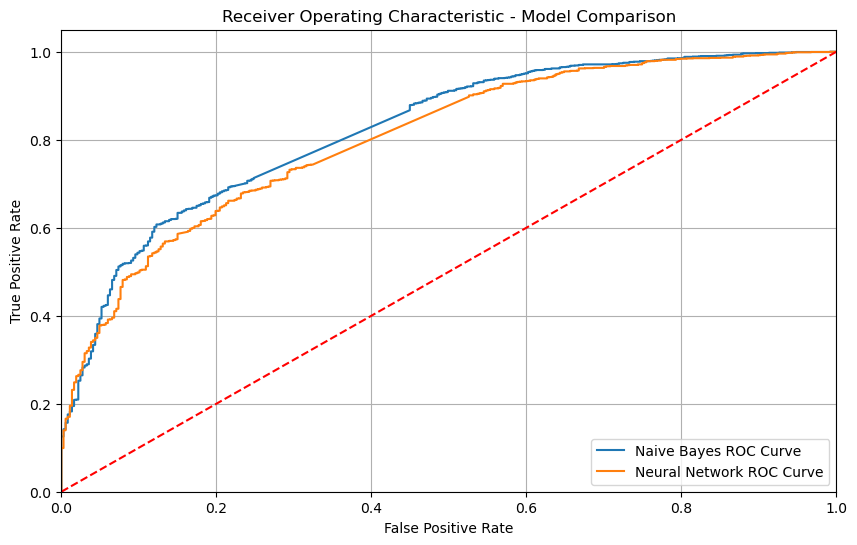

In [129]:
compare_models(nb_metrics, nn_metrics)

In [130]:
print('Error Analysis (Naive Bayes):')
analyze_model_performance(nb_model, X_tst, y_tst, vectorizer, steam_reviews_df.iloc[X_tst.index] if hasattr(X_tst, 'index') else steam_reviews_df)

Error Analysis (Naive Bayes):
Misclassified Samples (10):

Sample 1
Review: Was suprised by how well this game was done, had this game for a year and never considered playing it, another gta style game based in hong kong did not seem too appealing to me so i played it for a b...
Actual Sentiment: Negative
Predicted Sentiment: Positive

Sample 2
Review: Well worth the wait from the first game. Best puzzle based FPS story driven game yet. I love re playing the orignal and this. The co-op feature was awesome too while it lasted and added an extra edge ...
Actual Sentiment: Negative
Predicted Sentiment: Positive

Sample 3
Review: The best Total War game I have ever played, for so many reasons. Unique factions, unique diplomacy, unique heroes and spells, unique building trees etc. If you like Turned Based Strategy, get this gam...
Actual Sentiment: Negative
Predicted Sentiment: Positive

Sample 4
Review: Addictive!! I can equip only one item!?...
Actual Sentiment: Negative
Predicted Sentime

In [131]:
print('Error Analysis (Neural Network):')
analyze_model_performance(nn_model, X_tst, y_tst, vectorizer, steam_reviews_df.iloc[X_tst.index] if hasattr(X_tst, 'index') else steam_reviews_df)

Error Analysis (Neural Network):
Misclassified Samples (10):

Sample 1
Review: This is a really good game, the Unreal Engine's implementation makes it beautiful to look at. The Combat system is flawless on Campaign and although the sidequests are filled with puzzles and are very...
Actual Sentiment: Positive
Predicted Sentiment: Negative
Predicted Probability: 0.016664132475852966

Sample 2
Review:  Early Access Review...
Actual Sentiment: Negative
Predicted Sentiment: Positive
Predicted Probability: 0.9893738031387329

Sample 3
Review: WorkShop Support plz also good game...
Actual Sentiment: Positive
Predicted Sentiment: Negative
Predicted Probability: 0.312084436416626

Sample 4
Review: Not recommended its suck not fun and my antivirus reacts on it so i cant play it and i have norton security please dont but it!...
Actual Sentiment: Positive
Predicted Sentiment: Negative
Predicted Probability: 0.0445815846323967

Sample 5
Review: Best large number simulator on PC....
Actual Sentiment

In [132]:
print('Final Model Comparison:')
print(f'Naive Bayes F1-Score: {nb_metrics["test"]["f1_score"]}')
print(f'Neural Network F1-Score: {nn_metrics["test"]["f1_score"]}')
print(f'\nNaive Bayes Accuracy: {nb_metrics["test"]["accuracy"]}')
print(f'Neural Network Accuracy: {nn_metrics["test"]["accuracy"]}')

if nb_metrics['test']['f1_score'] > nn_metrics['test']['f1_score']:
    print('\nNaive Bayes performed better on the test set.')
    best_model = nb_model
    best_metrics = nb_metrics
else:
    print('\nNeural Network performed better on the test set.')
    best_model = nn_model
    best_metrics = nn_metrics

print(f"Best Model F1-Score: {best_metrics['test']['f1_score']}")
print(f"Best Model Accuracy: {best_metrics['test']['accuracy']}")


Final Model Comparison:
Naive Bayes F1-Score: 0.9110922946655376
Neural Network F1-Score: 0.9055718475073313

Naive Bayes Accuracy: 0.8425
Neural Network Accuracy: 0.839

Naive Bayes performed better on the test set.
Best Model F1-Score: 0.9110922946655376
Best Model Accuracy: 0.8425
